In the name of Allah

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [100]:
class ETL:
    def __init__(self, score_base=10):
        self.score_base = score_base
        
    
    def read_data_from_csv(self, path_review, path_movie):
        reviews = pd.read_csv(path_review)
        if path_movie is not None:
            movies = pd.read_csv(path_movie)
            return reviews, movies
        else:
            return reviews
    

    def transform_string_score(self, score: str):

        # remove white space
        while ' ' in score:
            score = score.replace(' ', '')

        score = score.upper()

        grade = ['A+', 'A', 'A-', 
                 'B+', 'B', 'B-', 
                 'C+', 'C', 'C-', 
                 'D+', 'D', 'D-', 
                 'E+', 'E', 'E-', 
                 'F+', 'F', 'F-']

        index = grade.index(score)
        return ((len(grade) - index)/len(grade))*self.score_base


    def transform_number_score(self, score: str):
        if '/' in score:
            score = score.split('/')
            base_number = float(score[1])
            if base_number == 0:
                return None
            score = float(score[0])
            return (score/base_number)*self.score_base
        else:
            return None


    def transform_score(self, score: str):
        if pd.notna(score):
            if score[0].isdigit():
                return self.transform_number_score(score)
            else:
                return self.transform_string_score(score)
        else:
            return None
    
    
    def transform_data(self, 
                       data: pd.core.frame.DataFrame, 
                       sentiment_col_name: str,
                       text_col_name: str, 
                       score_col_name: str):
        # extract useful columns
        df = None
        if score_col_name is not None:
            df = data[[sentiment_col_name, score_col_name, text_col_name]]
        else:
            df = data[[sentiment_col_name, text_col_name]]

        # remove NAN text
        df = df.where(df[text_col_name].notna()).dropna()

        # transform scoring
        if score_col_name is not None:
            df[score_col_name] = [self.transform_score(score=s) for s in df[score_col_name]]

        return df
    
    
    def transform(self, path_review, path_movie, sentiment_col_name, text_col_name, score_col_name):
        reviews, movies = self.read_data_from_csv(path_review=path_review, path_movie=path_movie)
        reviews = self.transform_data(reviews, 
                                      sentiment_col_name=sentiment_col_name,
                                      text_col_name=text_col_name, 
                                      score_col_name=score_col_name)
        return reviews
    

In [184]:
class EDA:
    def __init__(self, 
                 data, 
                 text_col_name="review_content", 
                 sentiment_col_name="review_type", 
                 score_col_name="review_score"):
        
        self.data = data
        self.text_col_name = text_col_name
        self.sentiment_col_name = sentiment_col_name
        self.score_col_name = score_col_name
        self.all_stat, self.fresh_stat, self.rotten_stat = self.statistics_of_data()
    
    
    def __len__(self):
        return len(self.data)
    
    
    def get_scores(self, review_type=None):
        scores = None
        if review_type is not None:
            scores = list(self.data[self.data[self.sentiment_col_name] == review_type][self.score_col_name])
        else:
            scores = list(self.data[self.score_col_name])
        scores = [x for x in scores if x == x]
        return np.sort(scores)
    
    
    def number_of_na(self, col):
        return self.data[col].isna().sum()
    
    
    def get_col_value(self, col, value):
        return self.data[self.data[col] == value]
    
    
    def class_numbers(self, labels=['Fresh', 'Rotten']):
        label = {}
        label[labels[0]] = len(eda.get_col_value(col=self.sentiment_col_name, value=labels[0]))
        label[labels[1]] = len(eda.get_col_value(col=self.sentiment_col_name, value=labels[1]))
        return label
        
    
    def get_statistics(self, review_type=None):
        scores = self.get_scores(review_type=review_type)
        texts = None
        if review_type is not None:
            texts = list(self.data[self.data[self.sentiment_col_name] == review_type][self.text_col_name])
        else:
            texts = list(self.data[self.text_col_name])
        texts_len = [len(t) for t in texts]
        statistics = {
            "len": len(scores),
            "score_mean": np.mean(scores),
            "score_median": np.median(scores),
            "score_std": np.std(scores),
            "score_min": np.min(scores),
            "score_max": np.max(scores),
            "texts_len_mean": np.mean(texts_len),
            "texts_len_median": np.median(texts_len),
            "texts_len_std": np.std(texts_len),
            "texts_len_min": np.min(texts_len),
            "texts_len_max": np.max(texts_len),
        }
        if review_type is None:
            label = self.class_numbers()
            for l in label:
                statistics[f'{l}_number'] = label[l]
        return statistics
    
    
    def statistics_of_data(self):
        all_data = self.get_statistics()
        fresh_data = self.get_statistics(review_type="Fresh")
        rotten_data = self.get_statistics(review_type="Rotten")
        return all_data, fresh_data, rotten_data
    
    
    def show_hist(self, x, bins=100, title="Title"):
        plt.hist(x, bins=bins)
        plt.title(title)
        plt.show()
    

In [102]:
etl = ETL(score_base=10)

In [99]:
reviews = etl.transform(path_review="./../../data/rotten_tomatoes_critic_reviews.csv", 
                        path_movie="./../../data/rotten_tomatoes_movies.csv", 
                        sentiment_col_name="review_type", 
                        text_col_name="review_content", 
                        score_col_name="review_score")

reviews

,review_type,review_score,review_content
3,Fresh,7.000000,Whether audiences will get behind The Lightnin...
6,Rotten,2.500000,Harry Potter knockoffs don't come more transpa...
7,Fresh,7.000000,"Percy Jackson isn't a great movie, but it's a ..."
8,Fresh,7.777778,"Fun, brisk and imaginative"
9,Fresh,6.000000,"Crammed with dragons, set-destroying fights an..."
...,...,...,...
1130006,Fresh,8.000000,As a spectacular war film with a powerful mora...
1130013,Fresh,7.000000,"Seen today, it's not only a startling indictme..."
1130014,Fresh,8.333333,A rousing visual spectacle that's a prequel of...
1130015,Rotten,7.000000,"A simple two-act story: Prelude to war, and th..."


In [185]:
eda = EDA(data=reviews, 
          text_col_name="review_content", 
          sentiment_col_name="review_type", 
          score_col_name="review_score")

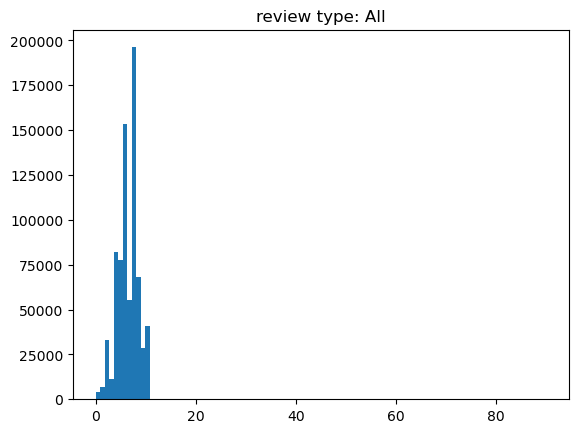

array([ 0. ,  0. ,  0. , ..., 87.5, 87.5, 90. ])

In [163]:
scores = eda.get_scores()
eda.show_hist(scores, bins=100, title="review type: All")
scores

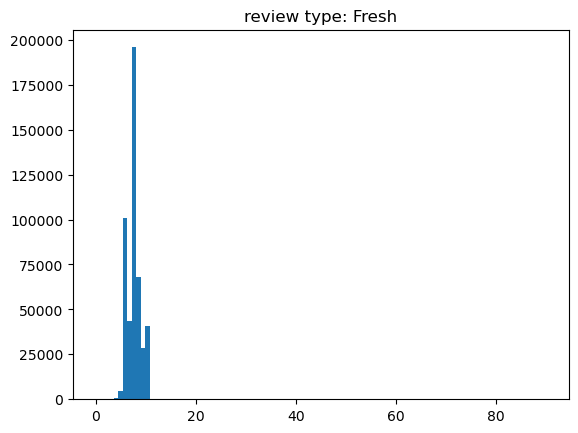

array([ 0. ,  0. ,  0. , ..., 87.5, 87.5, 90. ])

In [164]:
scores = eda.get_scores(review_type="Fresh")
eda.show_hist(scores, bins=100, title="review type: Fresh")
scores

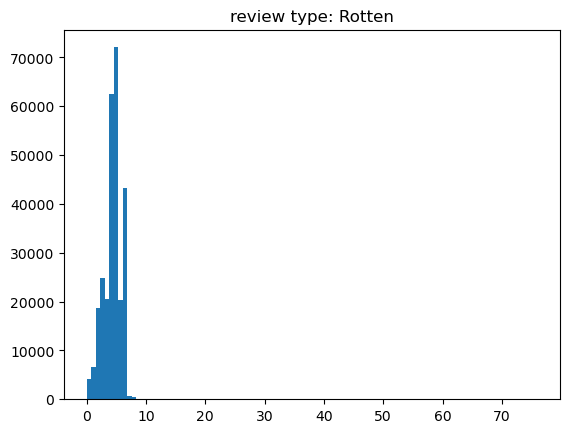

array([ 0.,  0.,  0., ..., 18., 76., 76.])

In [165]:
scores = eda.get_scores(review_type="Rotten")
eda.show_hist(scores, bins=100, title="review type: Rotten")
scores

In [189]:
label = eda.class_numbers(labels=['Fresh', 'Rotten'])
for l in label:
    print(f"{l}: {label[l]} ({label[l]/sum(label.values())*100:.0f}%)")

p = eda.number_of_na(col='review_score')/eda.__len__()
print(f"NA in review score: {p*100:.2f}%")

print()
print("### Statistic of All data ###")
for l in eda.all_stat:
    print(f"{l}:\t{eda.all_stat[l]:.3f}")

print()
print("### Statistic of Fresh data ###")
for l in eda.fresh_stat:
    print(f"{l}:\t{eda.fresh_stat[l]:.3f}")

print()
print("### Statistic of Rotten data ###")
for l in eda.rotten_stat:
    print(f"{l}:\t{eda.rotten_stat[l]:.3f}")

Fresh: 484127 (64%)
Rotten: 274582 (36%)
NA in review score: 0.21%

### Statistic of All data ###
len:	757111.000
score_mean:	6.489
score_median:	6.667
score_std:	2.079
score_min:	0.000
score_max:	90.000
texts_len_mean:	126.936
texts_len_median:	126.000
texts_len_std:	55.016
texts_len_min:	1.000
texts_len_max:	258.000
Fresh_number:	484127.000
Rotten_number:	274582.000

### Statistic of Fresh data ###
len:	483017.000
score_mean:	7.686
score_median:	7.778
score_std:	1.259
score_min:	0.000
score_max:	90.000
texts_len_mean:	128.561
texts_len_median:	128.000
texts_len_std:	55.174
texts_len_min:	1.000
texts_len_max:	257.000

### Statistic of Rotten data ###
len:	274094.000
score_mean:	4.381
score_median:	4.500
score_std:	1.477
score_min:	0.000
score_max:	76.000
texts_len_mean:	124.072
texts_len_median:	122.000
texts_len_std:	54.618
texts_len_min:	1.000
texts_len_max:	258.000


In [167]:
samples = eda.data.sample(10)
for c, t in zip(list(samples['review_content']), list(samples['review_type'])):
    print(f'##[{t}]##\n{c}')
    print("="*100)

##[Fresh]##
Arbitrage is a classy soap opera with a charismatic louse at its center, without Margin Call didactics, or the misplaced empathy of The Company Men.... It's simply good trash. You get the feeling that J.R. Ewing would approve.
##[Fresh]##
As well as making a hugely entertaining and funny film, writer and director Jason Reitman gives us plenty to ponder and taps into timeless themes that will hit a resonant chord with most.
##[Fresh]##
Come for more F-bombs than a season of "Deadwood." Stay for the aggressive religion bashing!
##[Rotten]##
The new film by the writer-director duo behind the 2011 hit The Intouchables is not as formulaic and manipulative but it lacks the single-minded coherence that was so crucial to that film's success.
##[Fresh]##
It transcends all other films that focus on human connection. It is raw, powerful, and so passionate that every gesture on-screen feels like a punch to the gut.
##[Fresh]##
"Wildlife" is the kind of movie whose low-key hush could ge

{'len': 757111,
 'score_mean': 6.489331318921392,
 'score_median': 6.666666666666666,
 'score_std': 2.079036067442119,
 'score_min': 0.0,
 'score_max': 90.0,
 'texts_len_mean': 126.9361678851839,
 'texts_len_median': 126.0,
 'texts_len_std': 55.01596288481473,
 'texts_len_min': 1,
 'texts_len_max': 258,
 'Fresh_number': 484127,
 'Rotten_number': 274582}